![PIC UPV PERTE Chip Chair Logo](https://www.pic-chair.upv.es/wp-content/uploads/2024/05/logo-upv-horizontal.png)
![PIC UPV PERTE Chip Chair Logo](https://www.pic-chair.upv.es/wp-content/uploads/2024/06/logos-perte-chip-1024x119.png)


# Laboratory 1. Waveguides

Welcome to our Photonic Integrated Circuits Laboratory! Throughout the course, we will be using a Python package called [GDSFactory](https://gdsfactory.github.io/gdsfactory/index.html). This is an open-source tool, and is a great alternative to other commercial software like Synopsys Optodesigner, Luceda Photonics, or Lumerical/Interconnect. Since it runs on Python, you have two options for executing your laboratory tasks:

1. **Local installation on your own PC** (Recommended): Please note that we will not spend class time on installing the software. However, feel free to reach out if you need help with the installation.

2. **Cloud Workspace**: Alternatively, you can use a cloud-based solution if the Local installation does not work.

## 0. Imports

For this laboratory you will need the following libraries:

In [10]:
import matplotlib.pyplot as plt
import numpy as np

import tidy3d as td

import gplugins as gp
import gplugins.tidy3d as gt
from gplugins import plot
from gplugins.common.config import PATH

nm = 1e-3
wavelength = np.linspace(1500, 1600,11) * nm
f = td.C_0 / wavelength


In [11]:
nitride_complex = td.material_library["Si3N4"]["Luke2015PMLStable"].eps_model(f)
nitride_index, nitride_k = td.Medium.eps_complex_to_nk(nitride_complex)
box_complex = td.material_library["SiO2"]["Horiba"].eps_model(f)
box_index, box_k = td.Medium.eps_complex_to_nk(box_complex)

## LO.1. Effective index of a waveguide

### Convergence Tests
We have asumed until now, that the **real** value of the effective index for each cross-section is the value provided by this mode-solver. However, this number relies on a numerical method, making it sensible to some input parameters, such as the selected grid. The objective of this section is to find the dependence of the **calculated** value of the effective index with the *grid_resolution* and the *max_grid_scaling*, the two parameters that we can modify from the automatic grid function used at the gt.modes.Waveguide() function.  <br>
- Consider a 1.2 um width deep waveguide (SiNx), with 0.3 um height operating at 1550 nm.
    - Sweep the *grid_resolution* between 10 and 100 in steps of 10. Plot the **calculated** effective index vs the *grid_resolution*. 
    - Select a value for the *grid_resolution* from the latter sweep (where the calculated index remains almost constant), and sweep the *max_grid_scaling* from 1.2 to 1.6 in steps of 0.1. Plot the **calculated** effective index vs the *max_grid_scaling*.
    - Conclude which will be the best configuration for the grid parameters for this particular case. 

2026-02-16 12:23:25.627 | INFO     | gplugins.tidy3d.modes:_data:266 - load data from .cache/Waveguide_cf92515ae4232c65.npz.


array([1.60524792+0.00010066j, 1.52829803+0.00017753j,
       1.45072999+0.00019228j, 1.43325817+0.00021838j])

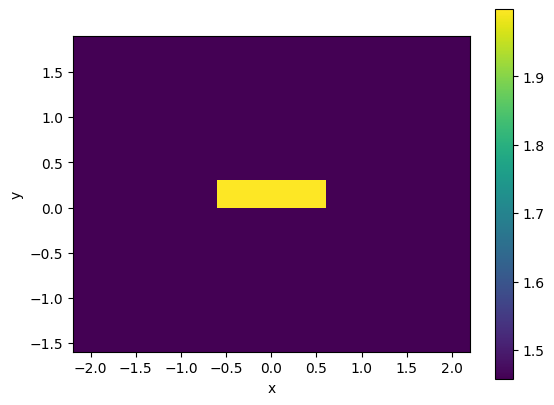

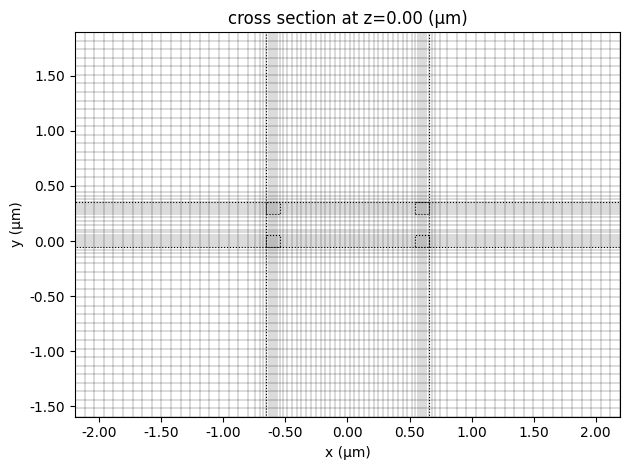

In [ ]:
deep_waveguide = gt.modes.Waveguide(
    # Geometrical Parameters
    core_width=1.2, # Waveguide width
    core_thickness=300 * nm, # Waveguide height 
    slab_thickness=0 * nm, # For shallow waveguides - Set to 0 if its a deep-etched waveguide.
    # Materials
    core_material='sin', #  Material of the waveguide
    clad_material='sio2', # Surrounding material
    # Modesolver Parameters
    wavelength=1550 * nm, # Wavelength to simulate
    num_modes=4, # Targeted number of modes to find 
    max_grid_scaling=1.5, # Parameters of the grid 
    grid_resolution=20, # Parameters of the grid
    cache_path='.cache/', # Important! In order to save simulation time, set your cache Path!
    precision='double',
)

deep_waveguide.plot_index()

# Student continue your code here ...



/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:14: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxf = sp.csr_matrix(sp.diags([-1, 1], [0, 1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:27: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxb = sp.csr_matrix(sp.diags([1, -1], [0, -1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/deri

2026-02-16 12:57:01.146 | INFO     | gplugins.tidy3d.modes:_data:306 - store data into .cache/Waveguide_09770a5eb4303d37.npz.


/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:14: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxf = sp.csr_matrix(sp.diags([-1, 1], [0, 1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:27: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxb = sp.csr_matrix(sp.diags([1, -1], [0, -1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/deri

2026-02-16 12:57:02.601 | INFO     | gplugins.tidy3d.modes:_data:306 - store data into .cache/Waveguide_972b4c36731994ce.npz.


/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:14: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxf = sp.csr_matrix(sp.diags([-1, 1], [0, 1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:27: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxb = sp.csr_matrix(sp.diags([1, -1], [0, -1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/deri

2026-02-16 12:57:04.834 | INFO     | gplugins.tidy3d.modes:_data:306 - store data into .cache/Waveguide_4aa1037aeb7bae0f.npz.


/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:14: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxf = sp.csr_matrix(sp.diags([-1, 1], [0, 1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:27: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxb = sp.csr_matrix(sp.diags([1, -1], [0, -1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/deri

2026-02-16 12:57:12.853 | INFO     | gplugins.tidy3d.modes:_data:306 - store data into .cache/Waveguide_4a7cfe924ea84b0e.npz.


/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:14: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxf = sp.csr_matrix(sp.diags([-1, 1], [0, 1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:27: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxb = sp.csr_matrix(sp.diags([1, -1], [0, -1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/deri

2026-02-16 12:57:18.840 | INFO     | gplugins.tidy3d.modes:_data:306 - store data into .cache/Waveguide_a75f11ee34197d65.npz.


/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:14: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxf = sp.csr_matrix(sp.diags([-1, 1], [0, 1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:27: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxb = sp.csr_matrix(sp.diags([1, -1], [0, -1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/deri

2026-02-16 12:57:33.424 | INFO     | gplugins.tidy3d.modes:_data:306 - store data into .cache/Waveguide_9f3aaac580067da9.npz.


/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:14: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxf = sp.csr_matrix(sp.diags([-1, 1], [0, 1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:27: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxb = sp.csr_matrix(sp.diags([1, -1], [0, -1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/deri

2026-02-16 12:57:48.359 | INFO     | gplugins.tidy3d.modes:_data:306 - store data into .cache/Waveguide_a122f2de27436370.npz.


/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:14: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxf = sp.csr_matrix(sp.diags([-1, 1], [0, 1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:27: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxb = sp.csr_matrix(sp.diags([1, -1], [0, -1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/deri

2026-02-16 12:58:11.989 | INFO     | gplugins.tidy3d.modes:_data:306 - store data into .cache/Waveguide_55052adad499f4e5.npz.


/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:14: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxf = sp.csr_matrix(sp.diags([-1, 1], [0, 1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:27: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxb = sp.csr_matrix(sp.diags([1, -1], [0, -1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/deri

2026-02-16 12:58:50.191 | INFO     | gplugins.tidy3d.modes:_data:306 - store data into .cache/Waveguide_3f00d13b3ed47c23.npz.


/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:14: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxf = sp.csr_matrix(sp.diags([-1, 1], [0, 1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:27: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxb = sp.csr_matrix(sp.diags([1, -1], [0, -1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/deri

2026-02-16 12:59:45.552 | INFO     | gplugins.tidy3d.modes:_data:306 - store data into .cache/Waveguide_734506418d905a04.npz.


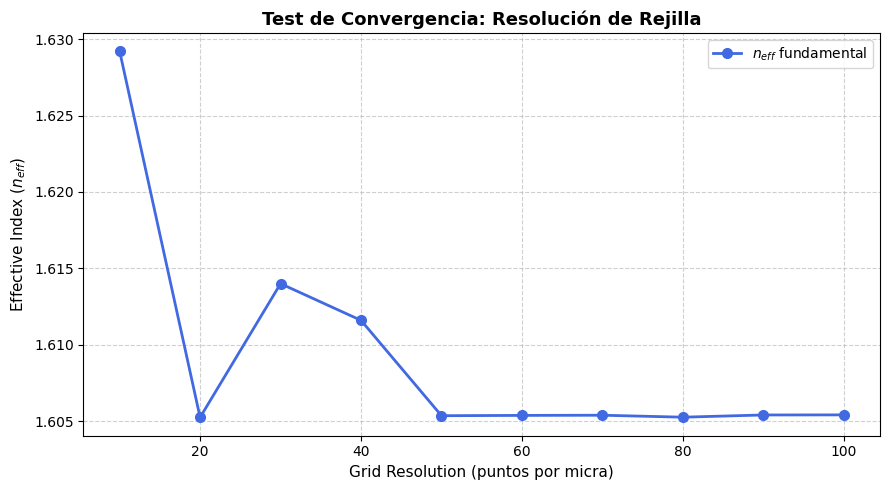

In [25]:
#BARRIDO DE GRID RESOLUTIONS
resolutions=np.arange(10,110,10)
neff_res= []

for res in resolutions: 
    deep_waveguide = gt.modes.Waveguide(
    # Geometrical Parameters
    core_width=1.2, # Waveguide width
    core_thickness=300 * nm, # Waveguide height 
    slab_thickness=0 * nm, # For shallow waveguides - Set to 0 if its a deep-etched waveguide.
    # Materials
    core_material='sin', #  Material of the waveguide
    clad_material='sio2', # Surrounding material
    # Modesolver Parameters
    wavelength=1550 * nm, # Wavelength to simulate
    num_modes=1, # Targeted number of modes to find 
    max_grid_scaling=1.5, # Parameters of the grid 
    grid_resolution=res, # Parameters of the grid
    cache_path='.cache/', # Important! In order to save simulation time, set your cache Path!
    precision='double',
)
    # Guardamos el neff del modo fundamental (índice 0)
    neff_res.append(deep_waveguide.n_eff.real)
    
# --- CONFIGURACIÓN DEL PLOT ---
plt.figure(figsize=(9, 5))

# Graficamos los datos del barrido
plt.plot(resolutions, neff_res, 'o-', color='royalblue', linewidth=2, markersize=7, label='$n_{eff}$ fundamental')

# Títulos y etiquetas
plt.title('Test de Convergencia: Resolución de Rejilla', fontsize=13, fontweight='bold')
plt.xlabel('Grid Resolution (puntos por micra)', fontsize=11)
plt.ylabel('Effective Index ($n_{eff}$)', fontsize=11)

# Formateo de ejes y rejilla
plt.grid(True, linestyle='--', alpha=0.6)
plt.ticklabel_format(useOffset=False) # Evita que Matplotlib simplifique los números en el eje Y
plt.legend()

plt.tight_layout()
plt.show()


2026-02-16 13:12:45.267 | INFO     | gplugins.tidy3d.modes:_data:266 - load data from .cache/Waveguide_17cb1fa5abd35339.npz.
2026-02-16 13:12:45.283 | INFO     | gplugins.tidy3d.modes:_data:266 - load data from .cache/Waveguide_686338e809798827.npz.


/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:14: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxf = sp.csr_matrix(sp.diags([-1, 1], [0, 1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:27: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxb = sp.csr_matrix(sp.diags([1, -1], [0, -1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/deri

2026-02-16 13:12:46.603 | INFO     | gplugins.tidy3d.modes:_data:306 - store data into .cache/Waveguide_61b4bc857f53db0c.npz.
2026-02-16 13:12:46.614 | INFO     | gplugins.tidy3d.modes:_data:266 - load data from .cache/Waveguide_972b4c36731994ce.npz.


/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:14: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxf = sp.csr_matrix(sp.diags([-1, 1], [0, 1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/derivatives.py:27: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  dxb = sp.csr_matrix(sp.diags([1, -1], [0, -1], shape=(Nx, Nx)))
/home/mjulben/pic-upv-lab1/.venv/lib/python3.12/site-packages/tidy3d/components/mode/deri

2026-02-16 13:12:57.526 | INFO     | gplugins.tidy3d.modes:_data:306 - store data into .cache/Waveguide_4cb3fe425fdc2963.npz.


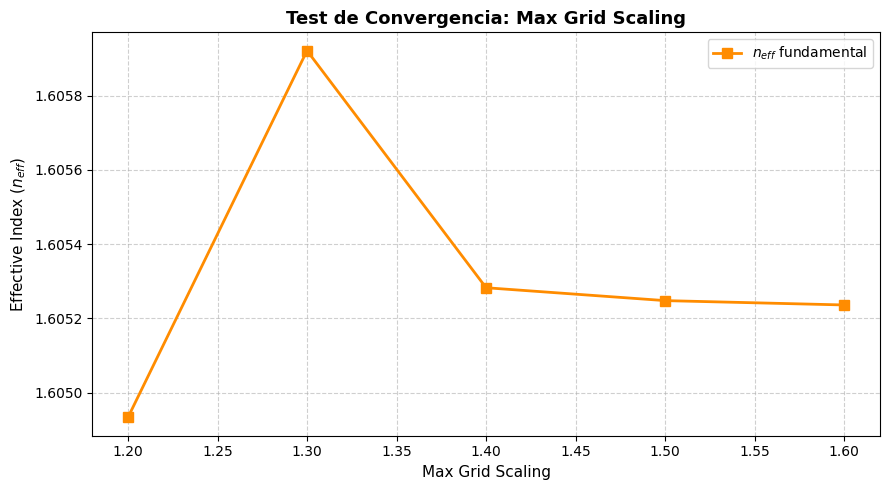

In [27]:
#BARRIDO DE MAX GRID RESOLUTIONS
scalings=np.linspace(1.2,1.6,5)
neff_scale= []
res_elegida= 20
for scale in scalings: 
    deep_waveguide = gt.modes.Waveguide(
    # Geometrical Parameters
    core_width=1.2, # Waveguide width
    core_thickness=300 * nm, # Waveguide height 
    slab_thickness=0 * nm, # For shallow waveguides - Set to 0 if its a deep-etched waveguide.
    # Materials
    core_material='sin', #  Material of the waveguide
    clad_material='sio2', # Surrounding material
    # Modesolver Parameters
    wavelength=1550 * nm, # Wavelength to simulate
    num_modes=1, # Targeted number of modes to find 
    max_grid_scaling=scale, # Parameters of the grid 
    grid_resolution=res_elegida, # Parameters of the grid
    cache_path='.cache/', # Important! In order to save simulation time, set your cache Path!
    precision='double',
)
    # Guardamos el neff del modo fundamental (índice 0)
    neff_scale.append(deep_waveguide.n_eff.real)
    
# --- CONFIGURACIÓN DEL PLOT 2 ---
plt.figure(figsize=(9, 5))
plt.plot(scalings, neff_scale, 's-', color='darkorange', linewidth=2, markersize=7, label='$n_{eff}$ fundamental')

plt.title('Test de Convergencia: Max Grid Scaling', fontsize=13, fontweight='bold')
plt.xlabel('Max Grid Scaling', fontsize=11)
plt.ylabel('Effective Index ($n_{eff}$)', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ticklabel_format(useOffset=False)
plt.legend()
plt.tight_layout()
plt.show()


## LO.2. Width dependence

- Perform a sweep of the **deep** waveguide width. Use the code provided in the following cell or program your own sweep. 

In [5]:
wavelength = ... # Student code here

deep_waveguide = gt.modes.Waveguide(
    wavelength=wavelength,
    core_width=1.2,
    core_material='sin',
    clad_material='sio2',
    core_thickness=300 * nm,
    slab_thickness=0 * nm,
    num_modes=4,
    cache_path='.cache/',
    precision='double',
    max_grid_scaling=1.2,
    grid_resolution=20, 
)

w = ... # Student code here

sweep_neff = gt.modes.sweep_n_eff(deep_waveguide, 
                             core_width=w)

sweep_tefraction = gt.modes.sweep_fraction_te(deep_waveguide,
                                              core_width=w)

plt.figure(figsize=(10, 5))
for k in range(sweep_neff.shape[1]):
    plt.scatter(w, sweep_neff[:,k].real,edgecolors='k',c=sweep_tefraction.sel(mode_index=k),vmin=0, vmax=1,label = '__nolegend__',cmap='bwr')
    plt.plot(w, sweep_neff[:,k].real,label=f'Mode {k}')

plt.title("Deep waveguide width sweep - 1550nm")
plt.xlabel("Width (um)")
plt.ylabel("neff")
plt.grid()
plt.hlines(np.mean(box_index), xmin=np.min(w), xmax=np.max(w), colors='k', linestyles='dashed',label='SiO2 index')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.colorbar(orientation='horizontal',fraction=0.04).set_label("TE fraction")

ValidationError: 1 validation error for Waveguide
wavelength
  float() argument must be a string or a real number, not 'ellipsis' (type=type_error)

## LO.3. Waveguide compact model

A compact model of an integrated photonic waveguide is a reduced-order mathematical model that describes the waveguide’s optical behavior—such as phase propagation, loss, and dispersion, using analytical or semi-analytical equations. Consider: 

Transfer function for propagation in a waveguide:

$$
H(\lambda)
= e^{-j\,\beta(\lambda)\,z}
= e^{-j\,\mathrm{Re}\{\beta(\lambda)\}\,z}\,
  e^{\mathrm{Im}\{\beta(\lambda)\}\,z}.
$$

Where 

$$
\beta(\lambda)
= \frac{2\pi}{\lambda}\,\mathrm{Re}\{n_\mathrm{eff}(\lambda)\}.
$$

Let's model the waveguide's effective index wavelength variation using a second order polynomial:

$$
n_\mathrm{eff}(\lambda)
= n_{1} + n_{2}\,(\lambda-\lambda_{0}) + n_{3}\,(\lambda-\lambda_{0})^{2}
$$

Where 

1. 
$$
n_\mathrm{eff}(\lambda_0) = n_1
$$
2. 
$$
n_g(\lambda_0) = n_1 - n_2\,\lambda_0
$$
3. 
$$
D = -\frac{2\,\lambda_0\,n_3}{c}\;\;[\mathrm{s}^2/\mathrm{m}]
$$

- Find the **compact models** of the following waveguides: 
    - Deep waveguide, height = 300nm, width = 1.2um 
    - Shallow waveguide, core height = 300nm, slab height = 150 nm, width = 1.2um 

**TIP**. Use the Lab0.1.Modesolver results (neff vs lambda) as starting point. Fit the results using a second order polynomial (with the lambda_0 shift) and relate the fit results to n_g and D values.

In [ ]:
# STUDENT! Put your code here.

## LO.4. Bend waveguide radius vs. loss – deep

The bend loss has three primary contributions:

1. Mode-mismatch loss
2. Radiation loss
3. Propagation loss

In [ ]:
bend_1550 = gt.modes.Waveguide(
    wavelength=1550 * nm,
    core_width=1.2,
    slab_thickness=0.0,
    core_material='sin',
    clad_material='sio2',
    core_thickness=300 * nm,
    num_modes=1,
    cache_path='.cache/',
    precision='double',
    max_grid_scaling=1.2,
    grid_resolution=30, 
    bend_radius=20, # Bend radius
)

bend_1550.plot_field(field_name="Ex", 
                     mode_index=0, # Field to be plotted
                     value='real', # Real - abs - imag
                     cmap='coolwarm',
                     xlim=(-1.5, 1.5), # Set the x and y limits
                     ylim=(-0.7, 1)) 

### Mode-mismatch loss

Bend waveguide mode differs slightly from the straight waveguide mode, wich yield into mode-convertion losses. We can calculate this factor with as the overlap of the latter two modes. 

This is already implemented on GDSfactory library: 

In [ ]:
radii = np.arange(20.0, 120,11)

mismatch = gt.modes.sweep_bend_mismatch(bend_1550, radii)

plt.plot(radii, 10 * np.log10(mismatch))
plt.title("Strip waveguide bend")
plt.xlabel("Radius (μm)")
plt.ylabel("Mismatch (dB)")

### Propagation loss

Consider the equivalent linear length of the quarter-circle bend. Light will attenuate following a trend quantified with the experimentally measured parameter $$\alpha [\mathrm{dB}/\mathrm{cm}]$$. It depends on the fabrication process mainly. We will add this loss (in dBs) to the mode-mismatch loss to calculate the total loss per bend. 

*We are not considering the radiation losses, mainly because is not easy to implement a quick simulation for this parameter. Under certain conditions, the main loss sources are the ones considered in this example


In [ ]:
dB_cm = 1.5  # dB/cm Technology loss - 
length = 0.5 * np.pi * radii * 1e-6
propagation_loss = dB_cm * length * 1e2
propagation_loss

plt.title("Bend loss for TE polarization")
plt.plot(radii, -10 * np.log10(mismatch), ".", label="Mode loss")
plt.plot(radii, propagation_loss, ".", label="Propagation loss")
plt.plot(radii, propagation_loss-10 * np.log10(mismatch), ".", label="Total loss")
plt.xlabel("Bend radius (um)")
plt.ylabel("Loss (dB)")
plt.legend()

- Use the code provided in this section to calculate the safe radius for 1.2 um width deep waveguides at 1.5 um. 

## EXTRA

All the past simulations were done considering as core material de Silicon Nitride (SiNx) and Silicon Dioxide (SiO2) as cladding material. Now, **simulate the Silicon-On-Insulator technology changing the core material to Silicon (Si)**. In this case, the dimensions will be 220 nm heigth and 500 nm width. 
1. Repeat the LO.1. wavelength behavior simulations, considering the updated materials and dimensions. 
2. Repeat the LO.3. width dependence analysis, now sweeping in a 300nm - 1um range. 
3. Find the safe radius for this technology. Consider sweeping the radius in a 5um to 30um range. 
4. **Compare the SiNx and SOI technologies** 

## Grading

LO.1. 2 Point <br> 
LO.2. 1 Points <br> 
LO.3. 3 Point <br> 
LO.4. 1 Points <br> 
**Total 7 Points** <br>
Extra (Up to) 3 Points
